In [3]:
import numpy as np
import matplotlib.pyplot as plt

from math import log, exp
from scipy.optimize import minimize

from sqlplus import *


In [4]:
# prepend_header('ex2data1.csv', 'ex1scr, ex2scr, admitted')

In [5]:
with dbopen('db') as c:
    c.write(read_csv('ex2data1.csv'), 'ex2data1')

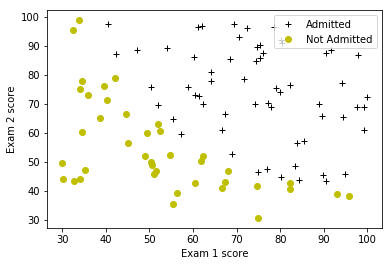

In [6]:
with dbopen('db') as c:
    admitted = c.rows('ex2data1', where='admitted=1')
    not_admitted = c.rows('ex2data1', where='admitted=0')
    a, = plt.plot(admitted['ex1scr'], admitted['ex2scr'], 'k+')
    b, = plt.plot(not_admitted['ex1scr'], not_admitted['ex2scr'], 'yo')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend([a, b], ['Admitted', 'Not Admitted'], loc=1)
    
    plt.show()
    

In [7]:
# TODO: You can vectorize the following, refer to numpy.power
def cost_function(X, y, theta):
    m = np.size(y)
    result = 0
    for i in range(m):
        h = 1 / (1 + exp(-theta.dot(X[i])))
        result += -y[i] * log(h) - (1 - y[i]) * log(1 - h)
    return result / m 
        

In [8]:
with dbopen('db') as c:
    X = []
    for r in c.read('ex2data1'):
        X.append([1, r['ex1scr'], r['ex2scr']])
    X = np.array(X)
    y = np.array(c.rows('ex2data1')['admitted'])
    theta = np.array([0, 0, 0])
    print(cost_function(X, y, theta))
    

0.69314718056


In [9]:
def gradient_descent(X, y, theta, alpha=0.01, max_iter=1500):
    m = np.size(y)
    for _ in range(max_iter):
        diffs = []
        # You can vectorize the following
        for i in range(m):
            h = 1.0 / (1 + exp(-theta.dot(X[i])))
            diffs.append(h - y[i])
        theta = theta - (alpha / m) * X.T.dot(diffs)
    return theta


In [10]:
with dbopen('db') as c:
    X = []
    for r in c.read('ex2data1'):
        X.append([1, r['ex1scr'], r['ex2scr']])
    X = np.array(X)
    y = np.array(c.rows('ex2data1')['admitted'])
    theta = np.array([0, 0, 0])
    print(gradient_descent(X, y, theta, 1, 1))
 

[  0.1         12.00921659  11.26284221]


In [11]:
# fminunc seems to be applying a different method
optres = minimize(lambda theta: cost_function(X, y, theta), [0, 0, 0], method='Nelder-Mead')
optres

 final_simplex: (array([[-25.16130062,   0.20623142,   0.20147143],
       [-25.16135807,   0.20623176,   0.20147199],
       [-25.1613519 ,   0.20623203,   0.20147171],
       [-25.16137971,   0.20623202,   0.20147188]]), array([ 0.2034977,  0.2034977,  0.2034977,  0.2034977]))
           fun: 0.20349770159952235
       message: 'Optimization terminated successfully.'
          nfev: 287
           nit: 157
        status: 0
       success: True
             x: array([-25.16130062,   0.20623142,   0.20147143])

In [12]:
optres.fun

0.20349770159952235

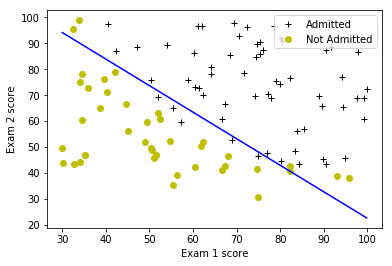

In [13]:
# plot decision boundary
def gety(x):
    theta = optres.x
    return (-theta[0] - theta[1] * x) / theta[2]
    
with dbopen('db') as c:
    admitted = c.rows('ex2data1', where='admitted=1')
    not_admitted = c.rows('ex2data1', where='admitted=0')
    a, = plt.plot(admitted['ex1scr'], admitted['ex2scr'], 'k+')
    b, = plt.plot(not_admitted['ex1scr'], not_admitted['ex2scr'], 'yo')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend([a, b], ['Admitted', 'Not Admitted'], loc=1)
    
    # find range
    beg, end = min(not_admitted['ex1scr']), max(admitted['ex1scr'])
    plt.plot([beg, end], [gety(beg), gety(end)], 'b-')
    
    plt.show()
    



In [14]:
# Work on 2 , 도대체 header 를 왜 안준거야?
# prepend_header('ex2data2.csv', 'test1, test2, accepted')
with dbopen('db') as c:
    c.write(read_csv('ex2data2.csv'), 'ex2data2')

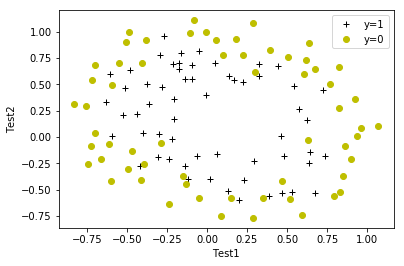

In [15]:
with dbopen('db') as c:
    accepted = c.rows('ex2data2', where='accepted=1')
    not_accepted = c.rows('ex2data2', where='accepted=0')
    a, = plt.plot(accepted['test1'], accepted['test2'], 'k+')
    b, = plt.plot(not_accepted['test1'], not_accepted['test2'], 'yo')
    plt.xlabel('Test1')
    plt.ylabel('Test2')
    plt.legend([a, b], ['y=1', 'y=0'], loc=1)
    
    plt.show()
    

In [16]:
def map_feature(X1, X2, degree):
    m = np.size(X1)
    result = np.ones((m, sum(range(degree + 2))))
    cnt = 1
    for i in range(1, degree + 1):
        for j in range(i + 1):
            result[:, cnt] = np.power(X1, j) * np.power(X2, i - j)
            cnt += 1
    return result
            

In [17]:

# pass lambda additionally
def cost_function(X, y, theta, l=1):
    m = np.size(y)
    h = 1 / (1 + np.exp(-X.dot(theta)))
    a = y.dot(np.log(h))
    b = (1 - y).dot(np.log(1 - h))
    c = theta[1:].dot(theta[1:])
    return (1 / m) * (-a - b) + l / (2 * m) * c


In [18]:
with dbopen('db') as c:
    data = c.rows('ex2data2')
    X = map_feature(data['test1'], data['test2'], 6)
    y = np.array(data['accepted'])
    theta = np.zeros(28)
    print(cost_function(X, y, theta, 1))


0.69314718056


In [19]:
optres = minimize(lambda theta: cost_function(X, y, theta, 1), np.zeros(28), method='BFGS');


In [20]:
optres.x

array([ 1.27268732,  1.18096639,  0.62557017, -1.43194213, -0.91761447,
       -2.0191981 , -0.17485809, -0.35703331, -0.36513062,  0.12375896,
       -1.19282545, -0.2746413 , -0.61603965, -0.05129655, -1.45843754,
       -0.4561327 , -0.29525836, -0.27782714, -0.04499776, -0.20569987,
       -0.2427034 , -0.92460079, -0.143892  , -0.32759308,  0.01543415,
       -0.29265624,  0.02762815, -1.04377836])

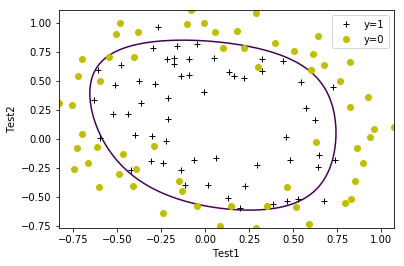

In [21]:
with dbopen('db') as c:
    accepted = c.rows('ex2data2', where='accepted=1')
    not_accepted = c.rows('ex2data2', where='accepted=0')
    a, = plt.plot(accepted['test1'], accepted['test2'], 'k+')
    b, = plt.plot(not_accepted['test1'], not_accepted['test2'], 'yo')
    plt.xlabel('Test1')
    plt.ylabel('Test2')
    plt.legend([a, b], ['y=1', 'y=0'], loc=1)
    
    begx, endx = min(not_accepted['test1']), max(not_accepted['test1'])
    begy, endy = min(not_accepted['test2']), max(not_accepted['test2'])
    xs = np.linspace(begx, endx, 100)
    ys = np.linspace(begy, endy, 100)
    XS, YS = np.meshgrid(xs, ys)
    zs = []
    for X, Y in zip(XS, YS):
        zs.append(map_feature(X, Y, 6).dot(optres.x))
    plt.contour(XS, YS, zs, [0])
    plt.show()
 


In [22]:
3 + 3

6